<a href="https://colab.research.google.com/github/mathewae/ML/blob/main/OrderBook_LGBM_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [96]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
pd.set_option('display.max_rows', 150)
pd.set_option('display.max_columns', 50)

import torch
import torch.nn as nn

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import d2_absolute_error_score, make_scorer, r2_score

from lightgbm import LGBMRegressor
!pip install scikit-optimize
from skopt import BayesSearchCV
from sklearn.feature_selection import RFECV
from scipy.stats import linregress

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import os
from termcolor import colored

# Opening file

file1 = open('/content/train.txt', 'r')
count = 0
ob_num = 0
ob = [[0] * 3 for _ in range(40)]
ordbook = [[0] * 2 for _ in range(10000)]

# File parsing

for line in file1:
    if ("price" in line.strip()):
#         print(pd.DataFrame(data=ob))
        ob_num = 0
        ordbook[count][1] = tuple([x for x in line.strip().split(' price: ')])
        ordbook[count][0] = pd.DataFrame(data=ob)
        ordbook[count][0].columns = ['price','amount','side']
        count +=1
    elif not ("=" in line.strip()):
        line = line.strip().split('\t')
        ob[ob_num][0] = int(line[0])
        ob[ob_num][1] = int(line[1])
        ob[ob_num][2] = line[2]
        ob_num += 1

# Closing files
file1.close()

ordbook = [row for row in ordbook if row[1] != 0]


In [178]:
def moments(x, wts, mid):
  wts /= np.linalg.norm(wts)
  M1 = np.average(x, weights = wts)
  M2c = np.average((x-M1)**2, weights = wts)
  M3c = np.average((x-M1)**3, weights = wts)
  M4c = np.average((x-M1)**4, weights = wts)

  skew = M3c / M2c**(3/2)
  kurt = M4c / M2c**2

  return [M1-mid, np.sqrt(M2c), np.cbrt(M3c), M4c**(0.25), skew, kurt]

# Data preproccesing - various features generation

def preproc(df, order, price):
# df, (order, price) = ordbook[3]

  direction = 1 if order == 'Sell' else -1

  df['quote'] = df['price']*df['amount']
  df['t'] = (-1)**(df['side']=='Buy')*df['price']
  df['lvl'] = df.groupby('side')['t'].rank().astype(int)

  df.drop('t', axis = 1, inplace = True)
  df = df.pivot(columns = 'side', index = 'lvl', values = ['quote', 'amount', 'price'])#.swaplevel(axis = 1)
  df[[('c_amount', 'Buy'), ('c_amount', 'Sell')]] = df[[('amount', 'Buy'), ('amount', 'Sell')]].cumsum()


  c_amount_frac = (df['c_amount', 'Buy']/df['c_amount', 'Sell']).to_numpy()**direction
  amount_frac = (df['amount', 'Buy']/df['amount', 'Sell']).to_numpy()**direction
  c_amount_prod =  np.cumprod(c_amount_frac)
  amount_prod = np.cumprod(amount_frac)

  mid_price = (df['price', 'Sell'].loc[1]+df['price', 'Buy'].loc[1])/2
  spread1 = (df['price', 'Sell'].loc[1]-df['price', 'Buy'].loc[1]).tolist()
  spread2 = (df['price', 'Sell'].loc[1]/df['price', 'Buy'].loc[1]-1).tolist()
  spread3 = (1/(df['price', 'Sell'].loc[1]-df['price', 'Buy'].loc[1])).tolist()
  spread4 = (1/(df['price', 'Sell'].loc[1]/df['price', 'Buy'].loc[1]-1)).tolist()
  wap = ((df['c_amount', 'Sell'][20]*df['price', 'Buy'][1]+df['price', 'Sell'][1]*df['c_amount', 'Buy'][20])/
    (df['c_amount', 'Sell'][20]+df['c_amount', 'Buy'][20]))

  res_s = linregress(df['price', 'Sell'], df['c_amount', 'Sell'])
  res_b = linregress(df['price', 'Buy'], df['c_amount', 'Buy'])

  res_s_lg = linregress(np.log(df['price', 'Sell']), np.log(df['c_amount', 'Sell']))
  res_b_lg = linregress(np.log(df['price', 'Buy']), np.log(df['c_amount', 'Buy']))

  features = [direction]
  features += [spread1]
  features += [spread2]
  features += [spread3]
  features += [spread4]

  features += [max(res_s.slope, res_b.slope)*np.log(spread1)]
  features += [max(res_s.slope, res_b.slope)*np.log(spread2)]
  features += [max(res_s.slope, res_b.slope)*np.log(spread3)]
  features += [max(res_s.slope, res_b.slope)*np.log(spread4)]

  features += [max(res_s_lg.slope, res_b_lg.slope)*np.log(spread1)]
  features += [max(res_s_lg.slope, res_b_lg.slope)*np.log(spread2)]
  features += [max(res_s_lg.slope, res_b_lg.slope)*np.log(spread3)]
  features += [max(res_s_lg.slope, res_b_lg.slope)*np.log(spread4)]
  features += [wap - mid_price]

  features += moments(df[[('price', 'Sell'), ('price', 'Buy')]].stack().to_numpy(dtype = float),
                      df[[('amount', 'Sell'), ('amount', 'Buy')]].stack().to_numpy(dtype = float),
                      mid_price)
  features += moments(df['price', 'Sell'].to_numpy(dtype = float),
                      df['amount', 'Sell'].to_numpy(dtype = float),
                      mid_price)
  features += moments(df['price', 'Buy'].to_numpy(dtype = float),
                      df['amount', 'Buy'].to_numpy(dtype = float),
                      mid_price)

  features += [res_s.rvalue]
  features += [res_s.slope]
  features += [res_s.stderr]
  features += [res_b.rvalue]
  features += [res_b.slope]
  features += [res_b.stderr]

  features += [res_s_lg.rvalue]
  features += [res_s_lg.slope]
  features += [res_s_lg.stderr]
  features += [res_b_lg.rvalue]
  features += [res_b_lg.slope]
  features += [res_b_lg.stderr]

  features += (df['c_amount', 'Sell']/df['c_amount', 'Buy']).apply(np.log).tolist()
  features += (df['c_amount']/max(df['c_amount', 'Sell'][20],df['c_amount', 'Buy'][20])).apply(np.log).diff().dropna().stack().tolist()

  features += amount_frac.tolist()
  features += amount_prod.tolist()

  return features, float(price)-mid_price

In [297]:
feat_names = ['dir', 'spread1', 'spread2', 'spread3', 'spread4', 'wap-mid_p']\
            +['spr1_sl', 'spr2_sl', 'spr3_sl', 'spr4_sl', 'spr1_sl_lg', 'spr2_sl_lg', 'spr3_sl_lg', 'spr4_sl_lg']\
            +['M1_all', 'M2c_all', 'M3c_all', 'M4c_all', 'skew_all', 'kurt_all']\
            +['M1_sell', 'M2c_sell', 'M3c_sell', 'M4c_sell', 'skew_sell', 'kurt_sell']\
            +['rvalue_sell', 'stderr_sell','slope_sell', 'rvalue_buy','slope_buy', 'stderr_buy']\
            +['lg_rvalue_sell', 'lg_stderr_sell','lg_slope_sell', 'lg_rvalue_buy','lg_slope_buy', 'lg_stderr_buy']\
            +['M1_buy', 'M2c_buy', 'M3c_buy', 'M4c_buy', 'skew_buy', 'kurt_buy']\
            +['frac_sb_{}'.format(i) for i in range(1, 21)]\
            +['norm_frac_{}_{}'.format('ss' if i%2==0 else 'bb', i//2) for i in range(2, 40)]\
            +['math_af_{}'.format(i) for i in range(1, 21)]\
            +['math_ap_{}'.format(i) for i in range(1, 21)]\

len(feat_names)

142

In [180]:
data = [preproc(ob.copy(), *com) for ob, com in ordbook]

In [181]:
# Getting features and labels separately
X, Y = zip(*data)
X = np.array(X)
Y = np.array(Y).reshape(-1)

In [187]:
# Bayesian search of optimal hyperparaeters for an LGBM regressor
params = dict()
params['learning_rate'] = (1e-3, 1e-0, 'log-uniform')
params['n_estimators'] = (200, 400)
params['num_leaves'] = (31, 255)
# params['max_depth'] = [-1]

scorer = make_scorer(d2_absolute_error_score)

reg = LGBMRegressor(objective = 'regression_l1',
                    # linear_tree = True,
                    colsample_bytree = 0.5,
                    boosting = 'dart',
                    verbose = -1);
search = BayesSearchCV(estimator=reg,
                       search_spaces=params,
                       scoring = scorer,
                       verbose = 10);
search.fit(X[:8000], Y[:8000])

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5; 1/1] START learning_rate=0.04890858436442291, n_estimators=325, num_leaves=123
[CV 1/5; 1/1] END learning_rate=0.04890858436442291, n_estimators=325, num_leaves=123;, score=0.612 total time=  17.0s
[CV 2/5; 1/1] START learning_rate=0.04890858436442291, n_estimators=325, num_leaves=123
[CV 2/5; 1/1] END learning_rate=0.04890858436442291, n_estimators=325, num_leaves=123;, score=0.606 total time=  17.9s
[CV 3/5; 1/1] START learning_rate=0.04890858436442291, n_estimators=325, num_leaves=123
[CV 3/5; 1/1] END learning_rate=0.04890858436442291, n_estimators=325, num_leaves=123;, score=0.597 total time=  16.7s
[CV 4/5; 1/1] START learning_rate=0.04890858436442291, n_estimators=325, num_leaves=123
[CV 4/5; 1/1] END learning_rate=0.04890858436442291, n_estimators=325, num_leaves=123;, score=0.606 total time=  16.7s
[CV 5/5; 1/1] START learning_rate=0.04890858436442291, n_estimators=325, num_leaves=123
[CV 5/5; 1/1] END learnin

BayesSearchCV(estimator=LGBMRegressor(boosting='dart', colsample_bytree=0.5,
                                      objective='regression_l1', verbose=-1),
              scoring=make_scorer(d2_absolute_error_score),
              search_spaces={'learning_rate': (0.001, 1.0, 'log-uniform'),
                             'n_estimators': (200, 400),
                             'num_leaves': (31, 255)},
              verbose=10)

In [189]:
# Precision estimate
print("Train precsion - {}".format((np.abs(search.best_estimator_.predict(X[:8000])-Y[:8000])<2.5).mean()))
print("Test precision - {}".format((np.abs(search.best_estimator_.predict(X[8000:])-Y[8000:])<2.5).mean()))

Train precsion - 0.603625
Test precision - 0.319


In [190]:
# Feature imortance
pd.DataFrame({'split' : search.best_estimator_.booster_.feature_importance('split'),
'gain' : search.best_estimator_.booster_.feature_importance('gain')},
index = feat_names).sort_values('gain', ascending = False)

,split,gain
dir,201,225458.972677
math_ap_13,125,15178.460229
math_ap_11,101,12180.690385
math_ap_14,135,12007.243126
frac_sb_14,144,11694.783977
math_ap_12,96,11542.333055
frac_sb_13,144,8714.551638
spread2,367,8337.168001
spread4,282,6930.076225
frac_sb_15,80,6241.003434


In [191]:
# Feature opimization - getting rid of statistically insignificant features on order to boost the score
reg = LGBMRegressor(**search.best_params_, objective = 'regression_l1',
                    # linear_tree = True,
                    colsample_bytree = 0.5,
                    boosting = 'dart',
                    verbose = -1)

rfecv = RFECV(
    estimator=reg,
    step=5,
    scoring=scorer,
    min_features_to_select = 60,
    verbose = 10
)

rfecv.fit(X[:8000], Y[:8000])

Fitting estimator with 142 features.
Fitting estimator with 137 features.
Fitting estimator with 132 features.
Fitting estimator with 127 features.
Fitting estimator with 122 features.
Fitting estimator with 117 features.
Fitting estimator with 112 features.
Fitting estimator with 107 features.
Fitting estimator with 102 features.
Fitting estimator with 97 features.
Fitting estimator with 92 features.
Fitting estimator with 87 features.
Fitting estimator with 82 features.
Fitting estimator with 77 features.
Fitting estimator with 72 features.
Fitting estimator with 67 features.
Fitting estimator with 62 features.
Fitting estimator with 142 features.
Fitting estimator with 137 features.
Fitting estimator with 132 features.
Fitting estimator with 127 features.
Fitting estimator with 122 features.
Fitting estimator with 117 features.
Fitting estimator with 112 features.
Fitting estimator with 107 features.
Fitting estimator with 102 features.
Fitting estimator with 97 features.
Fitting es

RFECV(estimator=LGBMRegressor(boosting='dart', colsample_bytree=0.5,
                              learning_rate=0.24774150000114636,
                              n_estimators=400, objective='regression_l1',
                              verbose=-1),
      min_features_to_select=60, scoring=make_scorer(d2_absolute_error_score),
      step=5, verbose=10)

In [192]:
# Feature importace
pd.Series(rfecv.ranking_, index = feat_names).sort_values()

dir                 1
norm_frac_bb_3      1
norm_frac_ss_3      1
norm_frac_bb_2      1
norm_frac_ss_2      1
norm_frac_bb_1      1
norm_frac_ss_1      1
frac_sb_16          1
norm_frac_ss_5      1
frac_sb_14          1
frac_sb_12          1
frac_sb_11          1
frac_sb_10          1
frac_sb_7           1
frac_sb_3           1
frac_sb_2           1
kurt_buy            1
frac_sb_13          1
skew_buy            1
norm_frac_bb_5      1
norm_frac_ss_7      1
math_ap_15          1
math_ap_14          1
math_ap_13          1
math_ap_12          1
math_ap_11          1
math_ap_10          1
math_ap_9           1
norm_frac_ss_6      1
math_ap_4           1
math_ap_2           1
math_af_8           1
math_af_3           1
math_af_2           1
math_af_1           1
norm_frac_bb_12     1
norm_frac_bb_7      1
math_ap_3           1
M4c_buy             1
norm_frac_ss_4      1
math_ap_20          1
skew_sell           1
spr2_sl_lg          1
spr1_sl_lg          1
spr4_sl             1
stderr_buy

In [194]:
# Fitting the training data with an optimized list of features
reg = LGBMRegressor(**search.best_params_, objective = 'regression_l1',
                    # linear_tree = True,
                    colsample_bytree = 0.5,
                    boosting = 'dart',
                    verbose = -1)
X_trunc = rfecv.transform(X)
reg.fit(X_trunc[:8000], Y[:8000])

print("Train precsion - {}".format((np.abs(reg.predict(X_trunc[:8000])-Y[:8000])<2.5).mean()))
print("Test precision - {}".format((np.abs(reg.predict(X_trunc[8000:])-Y[8000:])<2.5).mean()))

Train precsion - 0.592125
Test precision - 0.338


In [195]:
pd.DataFrame({'split' : reg.booster_.feature_importance('split'),
'gain' : reg.booster_.feature_importance('gain')},
index = np.array(feat_names)[rfecv.support_]).sort_values('gain', ascending = False)

,split,gain
dir,201,244095.945644
math_ap_13,249,21852.861328
math_ap_11,181,15117.039629
math_ap_12,193,14559.245434
frac_sb_14,195,13340.593096
frac_sb_13,256,13332.839133
math_ap_14,213,10370.484680
spread2,473,9476.127121
frac_sb_12,194,7751.669835
math_ap_10,155,7710.573262


In [196]:
params = dict()
params['learning_rate'] = (1e-2, 2e-0, 'log-uniform')
params['n_estimators'] = (300, 600)
params['num_leaves'] = (15, 63)
# params['max_depth'] = [-1]

scorer = make_scorer(d2_absolute_error_score)

reg = LGBMRegressor(objective = 'regression_l1',
                    # linear_tree = True,
                    # colsample_bytree = 0.5,
                    boosting = 'dart',
                    verbose = -1);
search = BayesSearchCV(estimator=reg,
                       search_spaces=params,
                       scoring = scorer,
                       verbose = 10);
X_trunc = rfecv.transform(X)
search.fit(X_trunc[:8000], Y[:8000])

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5; 1/1] START learning_rate=0.5769306258153681, n_estimators=355, num_leaves=60
[CV 1/5; 1/1] END learning_rate=0.5769306258153681, n_estimators=355, num_leaves=60;, score=0.683 total time=  12.1s
[CV 2/5; 1/1] START learning_rate=0.5769306258153681, n_estimators=355, num_leaves=60
[CV 2/5; 1/1] END learning_rate=0.5769306258153681, n_estimators=355, num_leaves=60;, score=0.675 total time=  10.1s
[CV 3/5; 1/1] START learning_rate=0.5769306258153681, n_estimators=355, num_leaves=60
[CV 3/5; 1/1] END learning_rate=0.5769306258153681, n_estimators=355, num_leaves=60;, score=0.687 total time=  11.0s
[CV 4/5; 1/1] START learning_rate=0.5769306258153681, n_estimators=355, num_leaves=60
[CV 4/5; 1/1] END learning_rate=0.5769306258153681, n_estimators=355, num_leaves=60;, score=0.666 total time=  10.6s
[CV 5/5; 1/1] START learning_rate=0.5769306258153681, n_estimators=355, num_leaves=60
[CV 5/5; 1/1] END learning_rate=0.576930625

BayesSearchCV(estimator=LGBMRegressor(boosting='dart',
                                      objective='regression_l1', verbose=-1),
              scoring=make_scorer(d2_absolute_error_score),
              search_spaces={'learning_rate': (0.01, 2.0, 'log-uniform'),
                             'n_estimators': (300, 600),
                             'num_leaves': (15, 63)},
              verbose=10)

In [197]:
# Final precision estimation
print("Train precsion - {}".format((np.abs(search.best_estimator_.predict(X_trunc[:8000])-Y[:8000])<2.5).mean()))
print("Test precision - {}".format((np.abs(search.best_estimator_.predict(X_trunc[8000:])-Y[8000:])<2.5).mean()))

Train precsion - 0.704875
Test precision - 0.36


In [211]:
reg = LGBMRegressor(**search.best_params_, objective = 'regression_l1',
                    # linear_tree = True,
                    # colsample_bytree = 0.5,
                    boosting = 'dart',
                    verbose = -1)
X_trunc = rfecv.transform(X)
reg.fit(X_trunc[~mask], Y[~mask])

print("Train precsion - {}".format((np.abs(reg.predict(X_trunc[~mask])-Y[~mask])<2.5).mean()))
print("Test precision - {}".format((np.abs(reg.predict(X_trunc[mask])-Y[mask])<2.5).mean()))

Train precsion - 0.6961797752808989
Test precision - 0.32


In [213]:
reg = LGBMRegressor(**search.best_params_, objective = 'regression_l1',
                    boosting = 'dart',
                    verbose = -1)
X_trunc = rfecv.transform(X)
reg.fit(X_trunc, Y)

print("Train precsion - {}".format((np.abs(reg.predict(X_trunc)-Y)<2.5).mean()))
# print("Test precision - {}".format((np.abs(reg.predict(X_trunc[mask])-Y[mask])<2.5).mean()))

Train precsion - 0.7


In [298]:
# Opening test file
file1 = open('/content/test.txt', 'r')
count = 0
ob_num = 0
ob = [[0] * 3 for _ in range(40)]
ordbook_test = [[0] * 2 for _ in range(10000)]


for line in file1:
    if ("price" in line.strip()):
#         print(pd.DataFrame(data=ob))
        ob_num = 0
        ordbook_test[count][1] = tuple([x for x in line.strip().split(' price: ')])
        ordbook_test[count][0] = pd.DataFrame(data=ob)
        ordbook_test[count][0].columns = ['price','amount','side']
        count +=1
    elif not ("=" in line.strip()):
        line = line.strip().split('\t')
        ob[ob_num][0] = int(line[0])
        ob[ob_num][1] = int(line[1])
        ob[ob_num][2] = line[2]
        ob_num += 1

# Closing files
file1.close()

ordbook_test = [row for row in ordbook_test if row[1] != 0]

In [253]:
# Data preprocessing for test data
def preproc_test(df, order):
# df, (order, price) = ordbook[3]

  direction = 1 if order == 'Sell price:' else -1

  df['quote'] = df['price']*df['amount']
  df['t'] = (-1)**(df['side']=='Buy')*df['price']
  df['lvl'] = df.groupby('side')['t'].rank().astype(int)

  df.drop('t', axis = 1, inplace = True)
  df = df.pivot(columns = 'side', index = 'lvl', values = ['quote', 'amount', 'price'])#.swaplevel(axis = 1)
  df[[('c_amount', 'Buy'), ('c_amount', 'Sell')]] = df[[('amount', 'Buy'), ('amount', 'Sell')]].cumsum()


  c_amount_frac = (df['c_amount', 'Buy']/df['c_amount', 'Sell']).to_numpy()**direction
  amount_frac = (df['amount', 'Buy']/df['amount', 'Sell']).to_numpy()**direction
  c_amount_prod =  np.cumprod(c_amount_frac)
  amount_prod = np.cumprod(amount_frac)

  mid_price = (df['price', 'Sell'].loc[1]+df['price', 'Buy'].loc[1])/2
  spread1 = (df['price', 'Sell'].loc[1]-df['price', 'Buy'].loc[1]).tolist()
  spread2 = (df['price', 'Sell'].loc[1]/df['price', 'Buy'].loc[1]-1).tolist()
  spread3 = (1/(df['price', 'Sell'].loc[1]-df['price', 'Buy'].loc[1])).tolist()
  spread4 = (1/(df['price', 'Sell'].loc[1]/df['price', 'Buy'].loc[1]-1)).tolist()
  wap = ((df['c_amount', 'Sell'][20]*df['price', 'Buy'][1]+df['price', 'Sell'][1]*df['c_amount', 'Buy'][20])/
    (df['c_amount', 'Sell'][20]+df['c_amount', 'Buy'][20]))

  res_s = linregress(df['price', 'Sell'], df['c_amount', 'Sell'])
  res_b = linregress(df['price', 'Buy'], df['c_amount', 'Buy'])

  res_s_lg = linregress(np.log(df['price', 'Sell']), np.log(df['c_amount', 'Sell']))
  res_b_lg = linregress(np.log(df['price', 'Buy']), np.log(df['c_amount', 'Buy']))

  features = [direction]
  features += [spread1]
  features += [spread2]
  features += [spread3]
  features += [spread4]

  features += [max(res_s.slope, res_b.slope)*np.log(spread1)]
  features += [max(res_s.slope, res_b.slope)*np.log(spread2)]
  features += [max(res_s.slope, res_b.slope)*np.log(spread3)]
  features += [max(res_s.slope, res_b.slope)*np.log(spread4)]

  features += [max(res_s_lg.slope, res_b_lg.slope)*np.log(spread1)]
  features += [max(res_s_lg.slope, res_b_lg.slope)*np.log(spread2)]
  features += [max(res_s_lg.slope, res_b_lg.slope)*np.log(spread3)]
  features += [max(res_s_lg.slope, res_b_lg.slope)*np.log(spread4)]
  features += [wap - mid_price]

  features += moments(df[[('price', 'Sell'), ('price', 'Buy')]].stack().to_numpy(dtype = float),
                      df[[('amount', 'Sell'), ('amount', 'Buy')]].stack().to_numpy(dtype = float),
                      mid_price)
  features += moments(df['price', 'Sell'].to_numpy(dtype = float),
                      df['amount', 'Sell'].to_numpy(dtype = float),
                      mid_price)
  features += moments(df['price', 'Buy'].to_numpy(dtype = float),
                      df['amount', 'Buy'].to_numpy(dtype = float),
                      mid_price)

  features += [res_s.rvalue]
  features += [res_s.slope]
  features += [res_s.stderr]
  features += [res_b.rvalue]
  features += [res_b.slope]
  features += [res_b.stderr]

  features += [res_s_lg.rvalue]
  features += [res_s_lg.slope]
  features += [res_s_lg.stderr]
  features += [res_b_lg.rvalue]
  features += [res_b_lg.slope]
  features += [res_b_lg.stderr]

  features += (df['c_amount', 'Sell']/df['c_amount', 'Buy']).apply(np.log).tolist()
  features += (df['c_amount']/max(df['c_amount', 'Sell'][20],df['c_amount', 'Buy'][20])).apply(np.log).diff().dropna().stack().tolist()

  features += amount_frac.tolist()
  features += amount_prod.tolist()

  return features, mid_price

In [254]:
feat_names = ['dir', 'spread1', 'spread2', 'spread3', 'spread4', 'wap-mid_p']\
            +['spr1_sl', 'spr2_sl', 'spr3_sl', 'spr4_sl', 'spr1_sl_lg', 'spr2_sl_lg', 'spr3_sl_lg', 'spr4_sl_lg']\
            +['M1_all', 'M2c_all', 'M3c_all', 'M4c_all', 'skew_all', 'kurt_all']\
            +['M1_sell', 'M2c_sell', 'M3c_sell', 'M4c_sell', 'skew_sell', 'kurt_sell']\
            +['rvalue_sell', 'stderr_sell','slope_sell', 'rvalue_buy','slope_buy', 'stderr_buy']\
            +['lg_rvalue_sell', 'lg_stderr_sell','lg_slope_sell', 'lg_rvalue_buy','lg_slope_buy', 'lg_stderr_buy']\
            +['M1_buy', 'M2c_buy', 'M3c_buy', 'M4c_buy', 'skew_buy', 'kurt_buy']\
            +['frac_sb_{}'.format(i) for i in range(1, 21)]\
            +['norm_frac_{}_{}'.format('ss' if i%2==0 else 'bb', i//2) for i in range(2, 40)]\
            +['math_af_{}'.format(i) for i in range(1, 21)]\
            +['math_ap_{}'.format(i) for i in range(1, 21)]\

data_test = [preproc_test(ob.copy(), *com) for ob, com in ordbook_test]

In [272]:
X_test, Y_mp_test = zip(*data_test)
X_test = np.array(X_test)
Y_mp_test = np.array(Y_mp_test).reshape(-1)

In [275]:
X_test_trunc = rfecv.transform(X_test)

In [295]:
Y_final = np.around((Y_mp_test + reg.predict(X_test_trunc))/5)*5
Y_final

array([130475., 130925., 131615., 131340., 131285., 130500., 130335.,
       131535., 130270., 132020., 130960., 130955., 130290., 131195.,
       131280., 131820., 130940., 130725., 131595., 132010., 131210.,
       132005., 131605., 130800., 130465.])

In [322]:
# FUNCTION FOR PLOTS
def OB_plot(lst, n_lst):
    num_plots = len(n_lst)
    fig, axes = plt.subplots(1, num_plots, figsize=(6 * num_plots, 5))

    if num_plots == 1:
        axes = [axes]  # If there's only one plot, convert it to a list of length 1

    for i, n in enumerate(n_lst):
        obsample = lst[n][0]
        obprice = int(lst[n][1][1])
        axes[i].set_title('Train order Book №' + str(n))

        sns.ecdfplot(x="price", weights="amount", stat="count", complementary=True, data=obsample[obsample.side == 'Buy'], ax=axes[i], color='g')
        sns.ecdfplot(x="price", weights="amount", stat="count", data=obsample[obsample.side == 'Sell'], ax=axes[i], color='r')
        axes[i].set_ylim(-5, max(lst[n][0]['amount'][21:].sum(), lst[n][0]['amount'][:20].sum()) + 250)

        l1 = axes[i].vlines(obprice, 0, max(lst[n][0]['amount'][21:].sum(), lst[n][0]['amount'][:20].sum()), color='black', ls='--',
                            label=str(lst[n][1][0]).upper() + ' ' + str('{:_}'.format(int(lst[n][1][1]))))

        axes[i].text((lst[n][0]['price'][19] + lst[n][0]['price'][20]) / 2 - 20,
                     max(lst[n][0]['amount'][21:].sum(), lst[n][0]['amount'][:20].sum()) + 100,
                     'Spread = ' + str(lst[n][0]['price'][19] - lst[n][0]['price'][20]), fontsize=11,
                     bbox=dict(facecolor='grey', alpha=0.2))
        axes[i].text(((lst[n][0]['price'][19] + lst[n][0]['price'][20])/2) - 30,
                     max(lst[n][0]['amount'][21:].sum(), lst[n][0]['amount'][:20].sum()) + 25,
                     'MidPrice =' + str('{:_}'.format(int((lst[n][0]['price'][19] + lst[n][0]['price'][20])/2))), fontsize=11,
                     bbox=dict(facecolor='blue', alpha=0.2))

        axes[i].legend(fontsize=11)
        axes[i].set_xlabel("Price")
        axes[i].set_ylabel("Coins amount")

    plt.tight_layout()  # Ensures that the subplots do not overlap
    plt.show()


In [332]:
# FUNCTION FOR TEST PLOTS
def OB_plot_t(lst, n_lst):
    num_plots = len(n_lst)
    fig, axes = plt.subplots(1, num_plots, figsize=(6 * num_plots, 5))

    if num_plots == 1:
        axes = [axes]  # If there's only one plot, convert it to a list of length 1

    for i, n in enumerate(n_lst):
        obsample = lst[n][0]
        axes[i].set_title('Test order Book №' + str(n))

        sns.ecdfplot(x="price", weights="amount", stat="count", complementary=True, data=obsample[obsample.side == 'Buy'], ax=axes[i], color='g')
        sns.ecdfplot(x="price", weights="amount", stat="count", data=obsample[obsample.side == 'Sell'], ax=axes[i], color='r')
        axes[i].set_ylim(-5, max(lst[n][0]['amount'][21:].sum(), lst[n][0]['amount'][:20].sum()) + 270)

        l1 = axes[i].vlines(int(Y_final[n]), 0, max(lst[n][0]['amount'][21:].sum(), lst[n][0]['amount'][:20].sum()), color='blue', ls='-',
                            label="Predicted price " + str(lst[n][1][0]).upper())

        axes[i].text((lst[n][0]['price'][19] + lst[n][0]['price'][20]) / 2 - 20,
                     max(lst[n][0]['amount'][21:].sum(), lst[n][0]['amount'][:20].sum()) + 115,
                     'Spread = ' + str(lst[n][0]['price'][19] - lst[n][0]['price'][20]), fontsize=11,
                     bbox=dict(facecolor='grey', alpha=0.2))
        axes[i].text(((lst[n][0]['price'][19] + lst[n][0]['price'][20])/2) - 30,
                     max(lst[n][0]['amount'][21:].sum(), lst[n][0]['amount'][:20].sum()) + 45,
                     'MidPrice =' + str('{:_}'.format(int((lst[n][0]['price'][19] + lst[n][0]['price'][20])/2))), fontsize=11,
                     bbox=dict(facecolor='blue', alpha=0.2))

        axes[i].legend(fontsize=11)
        axes[i].set_xlabel("Price")
        axes[i].set_ylabel("Coins amount")

    plt.tight_layout()  # Ensures that the subplots do not overlap
    plt.show()

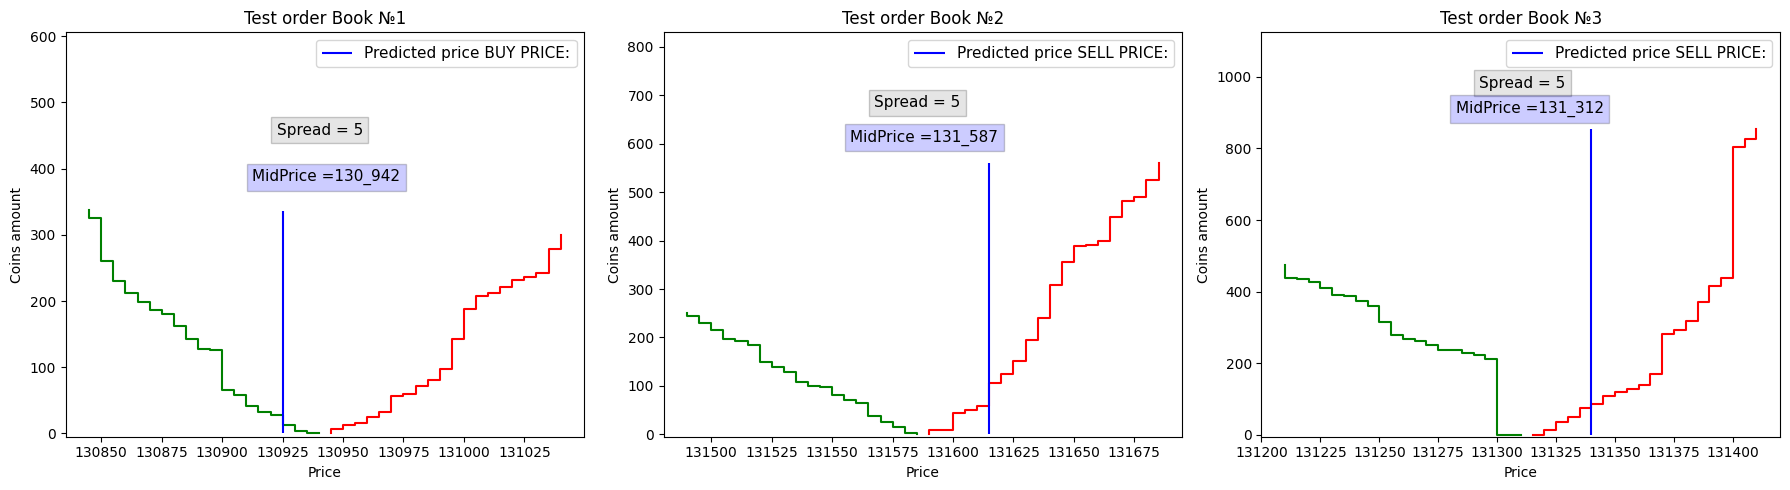

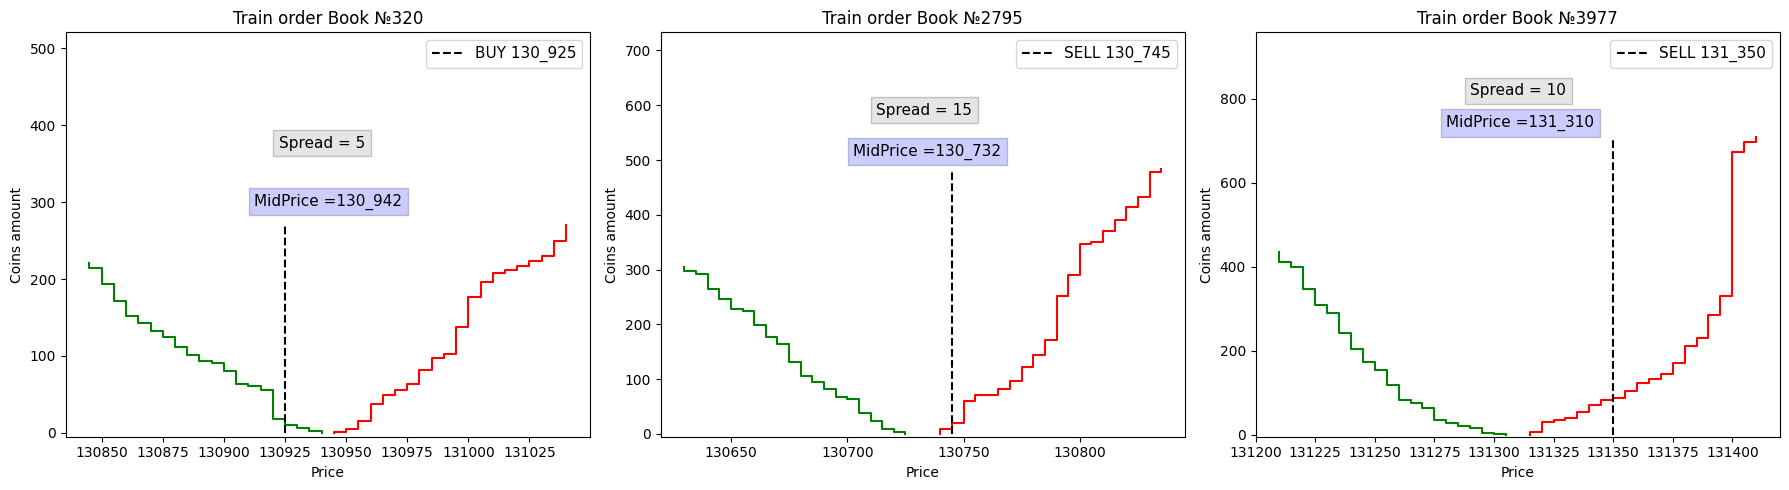

In [333]:
# Exapmle of plots for three inition LOBs with the similar ones from the training set
n = [1, 2, 3]
OB_plot_t(ordbook_test, n)
OB_plot(ordbook, [320, 2795, 3977])

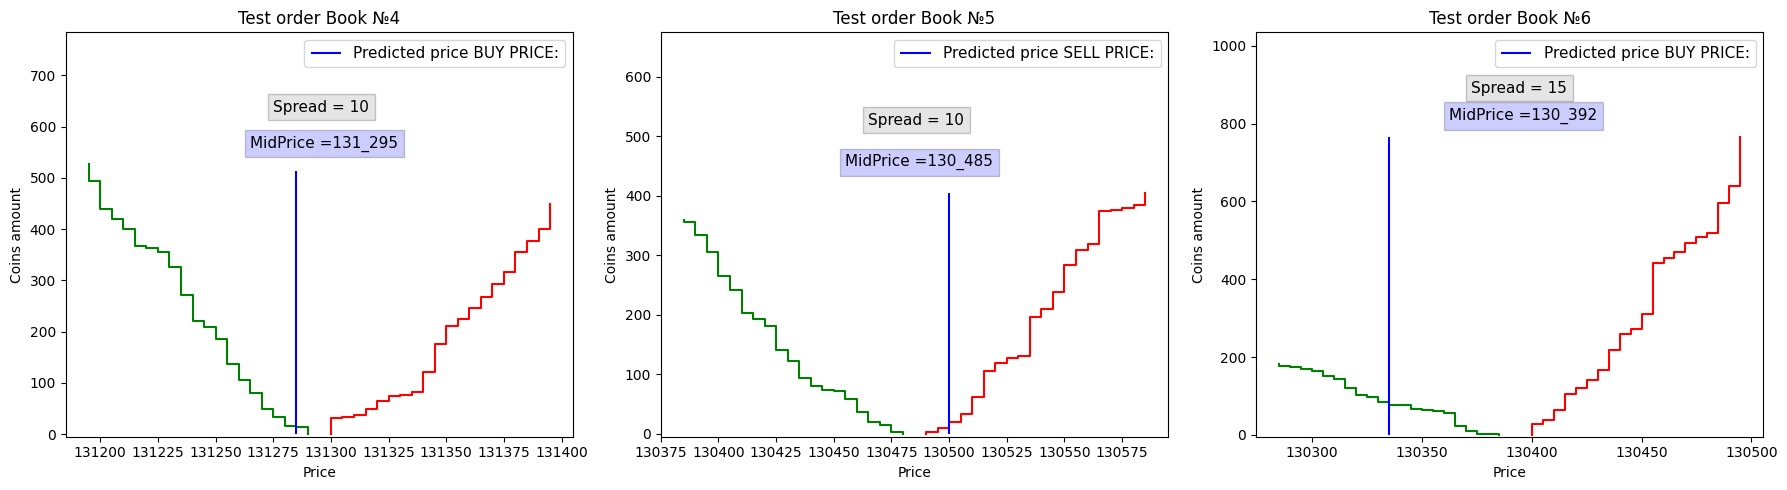

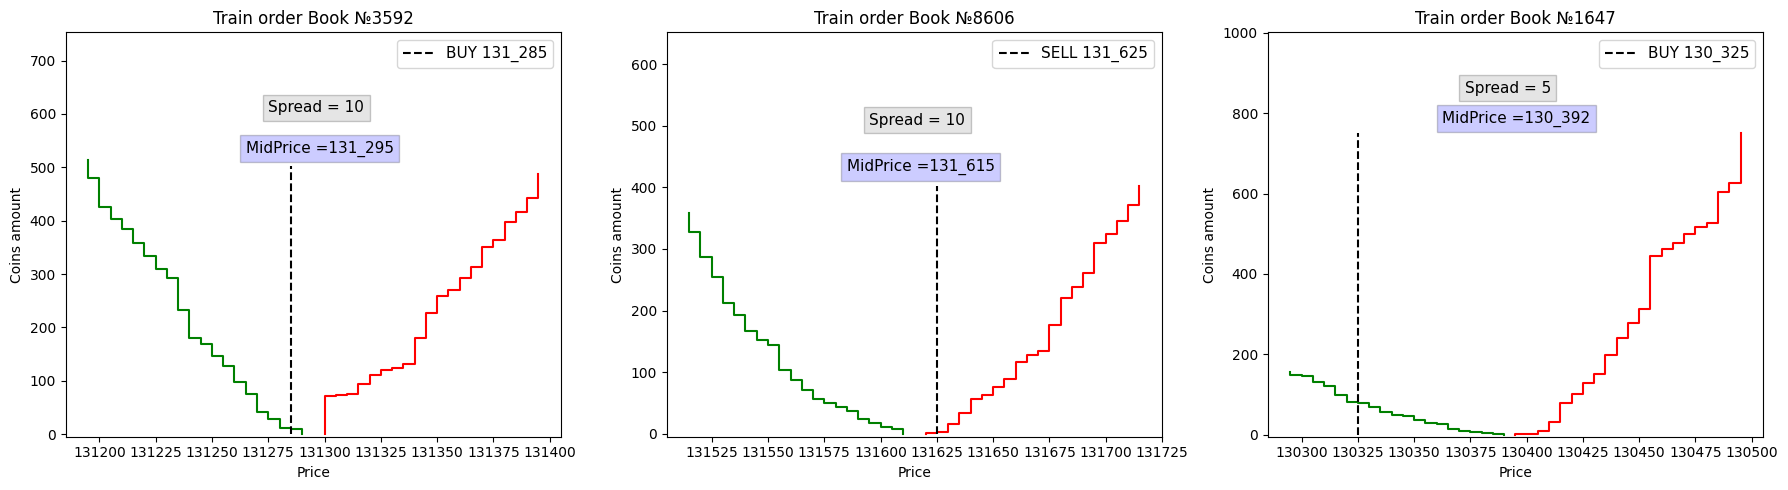

In [334]:
n = [4, 5, 6]
OB_plot_t(ordbook_test, n)
OB_plot(ordbook, [3592, 8606, 1647])